In [40]:
import torch as th
import numpy as np
from torch.utils.data import TensorDataset, DataLoader
import matplotlib.pyplot as plt
import torch.optim as optim
from tqdm.auto import trange
import torch.nn as nn

import time 

# Dataset
As a first thing, I will create the dataset that, as explained in the paper, is comopsed by a set of 64 arrays of length 6, containing integer numbers.  
Our goal is to detect whether this array is mirror symmetric or not, therefore I will use as a target a second array, of length 64, that will assume the value 1 whenever the corresponding array is mirror-symmetric and 0 otherwise.  
The paper does not specify how the 6 digits arrays should be generated, therefore I decided to genrate them at random, with an equal probability of generating a mirror symmetric and a non-mirror symmetric array.  
  
For testing purposes, I will also create a test set.

In [41]:
train_elements: int = 64
test_elements: int = 32

In [42]:
def create_input(n_inputs):
    input = th.empty((n_inputs, 6), dtype=th.float32)
    output = th.empty(n_inputs, dtype = th.float32)

    for i in range(n_inputs):
        output[i] = th.randint(low=0, high=2, size=(1,))

        maxnumber = 9

        if output[i] == 0:
            input[i, :] = th.randint(low=0, high=maxnumber, size=(6,))
        elif output[i] == 1:
            input[i, :3] = th.randint(low=0, high=maxnumber, size=(3,))
            input[i, 3] = input[i, 2]
            input[i, 4] = input[i, 1]
            input[i, 5] = input[i, 0]
        else:
            print("error")
    return input, output

In [43]:
train_input, train_output = create_input(train_elements)

test_input, test_output = create_input(test_elements)

In order to use pytorch, I will put the generated datasets into a DataLoader. Since the batch size used for the gradient descent is not specified in the paper, I will take it as equal to the number of datapoints, performing a full batch gradient descent.

In [44]:
train_dataset = TensorDataset(train_input, train_output)
train_loader = DataLoader(train_dataset, batch_size=train_elements, shuffle=True)

test_dataset = TensorDataset(test_input, test_output)
test_loader = DataLoader(test_dataset, batch_size=test_elements, shuffle=False)

## The model
By reading the paper, it is clear that the authors are using a fully connected neural network with one hidden layer and two hidden units, with sigmoid activation function. This network can be implemented as follows in pytorch.

In [45]:
class Model(nn.Module):
    def __init__(self, w1, w2, b1, b2, n_units):
        super(Model, self).__init__()
        self.fc1 = nn.Linear(in_features=6, out_features=n_units, bias=True)
        self.fc2 = nn.Linear(in_features=n_units, out_features=1, bias=True)
        self.sigmoid = nn.Sigmoid()

        # Initialise weights
        with th.no_grad():
            self.fc1.weight = nn.Parameter(w1)
            self.fc1.bias = nn.Parameter(b1)
            self.fc2.weight = nn.Parameter(w2)
            self.fc2.bias = nn.Parameter(b2)

    def forward(self, x):
        x = self.fc1(x)
        x = self.sigmoid(x)
        x = self.fc2(x)
        x = self.sigmoid(x)
        return x
    

As specified in the paper, the weights must be initalised with random numbers between -0.3 and 0.3, sampled uniformly. The optimiser is gradient descent with learning rate 0.1 and momentum 0.9.  
Finally, the loss used by the paper has the form:
$$
L = \frac{1}{2}\sum_{i = 1}^{N} (y_{true} - y_{pred})^2
$$
with $N$ number of $y_{true} - y_{pred}$ pairs.  
This loss can be obtained by modifying the pytorch [MSE Loss](https://pytorch.org/docs/stable/generated/torch.nn.MSELoss.html#torch.nn.MSELoss) function with reduction = "sum".

In [46]:
class CustomMSELoss(nn.MSELoss):
    def __init__(self, size_average=None, reduce=None, reduction='sum'):
        super(CustomMSELoss, self).__init__(size_average, reduce, reduction)

    def forward(self, input, target):
        mse_loss = super(CustomMSELoss, self).forward(input, target)
        scaled_loss = 0.5 * mse_loss
        return scaled_loss

Here, I will define some functions that I will use to train the model and plot the results.

In [47]:
def train_model(model, optimizer, criterion, train_loader, test_loader, EPOCHS, n_units):
    train_losses = []
    train_acc = []
    test_losses = []
    test_acc = []

    w1 = np.empty((EPOCHS, n_units, 6), dtype = np.float32)
    w2 = np.empty((EPOCHS, 1, n_units), dtype = np.float32)
    b1 = np.empty((EPOCHS, 1, n_units), dtype = np.float32)
    b2 = np.empty((EPOCHS, 1), dtype = np.float32)


    for epoch in trange(EPOCHS):
        model.train()

        train_loss = 0
        n_elements: int = 0
        batch_acc = 0

        for _, (input, output) in enumerate(train_loader):
            result = model(input)
            loss = criterion(result.reshape(result.shape[0]), output)
            n_elements += input.shape[0]

            optimizer.zero_grad()

            loss.backward()

            optimizer.step()   

            train_loss += loss.detach().item()

            y_pred = th.round(result).reshape(result.shape[0])
            batch_acc += th.sum(th.abs(output - y_pred) < 0.5).item()

        train_losses.append(train_loss/n_elements)
        train_acc.append(batch_acc/n_elements)

        w1[epoch] = model.fc1.weight.clone().detach()
        w2[epoch] = model.fc2.weight.clone().detach()
        b1[epoch] = model.fc1.bias.clone().detach()
        b2[epoch] = model.fc2.bias.clone().detach()

        model.eval()
        with th.no_grad():
            test_elements: int = 0
            test_loss = 0
            batch_test_acc = 0
            for _, (input, output) in enumerate(test_loader):
                result_test = model(input)
                y_pred_test = th.round(result_test).reshape(result_test.shape[0])
                test_loss += criterion(result_test.reshape(result_test.shape[0]), output).detach().item()
                batch_test_acc += th.sum(th.abs(output - y_pred_test) < 0.5).item()

                test_elements += input.shape[0]
            
            test_losses.append(test_loss / test_elements)
            test_acc.append(batch_test_acc / test_elements)

    return model, train_losses, train_acc, test_losses, test_acc, w1, w2, b1, b2

def plot_loss_acc(train_losses, train_acc, test_losses, test_acc):
    fig, axs = plt.subplots(1, 2, figsize=(15, 5))

    EPOCHS = len(train_losses)

    axs[0].plot(train_losses, label = "Train")
    axs[0].plot(test_losses, label = "Test")
    axs[0].plot(np.zeros(EPOCHS), linestyle='--', alpha=0.5)
    axs[0].legend()

    axs[1].plot(train_acc, label = "Train")
    axs[1].plot(test_acc, label = "Test")
    axs[1].plot(np.ones(EPOCHS), linestyle='--', alpha=0.5)
    axs[1].plot(np.ones(EPOCHS) * 0.5, linestyle='--', alpha=0.5)
    axs[1].legend()
    axs[1].set_ylim(0, 1.2)

    plt.show()

def plot_weights_biases(w1, w2, b1, b2):
    fig, axs = plt.subplots(2, 2, figsize=(15, 10))

    axs[0, 0].set_title("W1 - Hidden unit 1")
    axs[0, 1].set_title("W1 - Hidden unit 2")
    for i in range(w1.shape[2]):
        axs[0, 0].plot(w1[:, 0, i], label = "w" + str(i))
        axs[0, 1].plot(w1[:, 1, i], label = "w" + str(i))
    axs[0, 0].legend()
    axs[0, 1].legend()

    maxvalue = np.ceil(np.max(np.abs(w1))).item()

    axs[0, 0].set_ylim(- maxvalue, maxvalue)
    axs[0, 1].set_ylim(- maxvalue, maxvalue)

    axs[1, 0].set_title("W2")

    for i in range(w2.shape[2]):
        axs[1, 0].plot(w2[:, 0, i], label = "w" + str(i))
    axs[1, 0].legend()

    axs[1, 1].set_title("Biases")

    for i in range(b1.shape[2]):
        axs[1, 1].plot(b1[:, 0, i], label = "Hidden unit  " + str(i + 1))

    axs[1, 1].plot(b2[:, 0], label = "Output unit")

    axs[1, 1].legend()

    plt.show()


def print_results(w1, w2, b1, b2, train_losses, test_losses, train_acc, test_acc):
    print("Final weights ")
    for i in range(w1.shape[1]):
        print(w1[-1, i, :])

    print("\nFinal biases for the hidden layer")
    for i in range(b1.shape[2]):
        print(b1[-1, 0, i])

    print("\nFinal weights for the output layer")
    for i in range(w2.shape[2]):
        print(w2[-1, 0, i])

    print("\nFinal bias for the output layer")
    print(b2[-1, 0])

    print(f"\nFinal train and test losses: {train_losses[-1]:.4e}, {test_losses[-1]:.4e}")
    print(f"Final train and test accuracies: {train_acc[-1]:.4f}, {test_acc[-1]:.4f}")

In the following cell, I will define some constants and initialise the weights, that are made as follows:
- w1: 2 x 6 vector containing all the weights that connect the input with the first (row 0) and second (row 1) hidden unit.
- b1: biases of the two hidden units
- w2: weights that connect the two hidden units with the output
- b2: bias of the output unit

In [48]:
LEARNING_RATE = 0.1
MOMENTUM = 0.9

EPOCHS: int = 1425

w1_init = (np.random.rand(2, 6) - 0.5) * 0.6
b1_init = (np.random.rand(2) - 0.5) * 0.6
w2_init = (np.random.rand(1, 2) - 0.5) * 0.6
b2_init = (np.random.rand(1) - 0.5) * 0.6

print("Initial weights")
print(w1_init)
print(w2_init)

print("\nInitial biases")
print(b1_init)
print(b2_init)

Initial weights
[[ 0.26127107 -0.09892935 -0.13634691  0.19485579  0.24861309  0.11658397]
 [ 0.09992239 -0.13174725 -0.12786912  0.03221973 -0.10449675  0.02461851]]
[[ 0.05866801 -0.12392113]]

Initial biases
[ 0.06436992 -0.10067858]
[-0.09559622]


In [49]:
n_units = 2

model = Model(th.tensor(w1_init, dtype=th.float32),
              th.tensor(w2_init, dtype=th.float32),
              th.tensor(b1_init, dtype=th.float32),
              th.tensor(b2_init, dtype=th.float32),
              n_units)

optimizer = optim.SGD(model.parameters(), lr=LEARNING_RATE, momentum=MOMENTUM)

criterion = CustomMSELoss()

time_start = time.time()
model, train_losses, train_acc, test_losses, test_acc, w1, w2, b1, b2 = train_model(model, optimizer, criterion, train_loader, test_loader, EPOCHS, n_units)

print("Total time: ", time.time() - time_start)

100%|██████████| 1425/1425 [00:02<00:00, 506.09it/s]

Total time:  2.8254001140594482


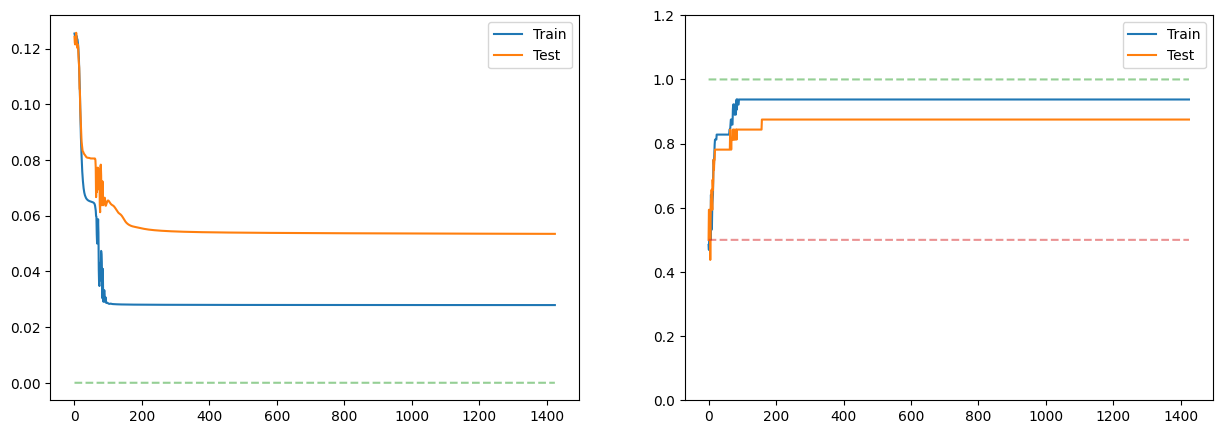

In [50]:
plot_loss_acc(train_losses, train_acc, test_losses, test_acc)

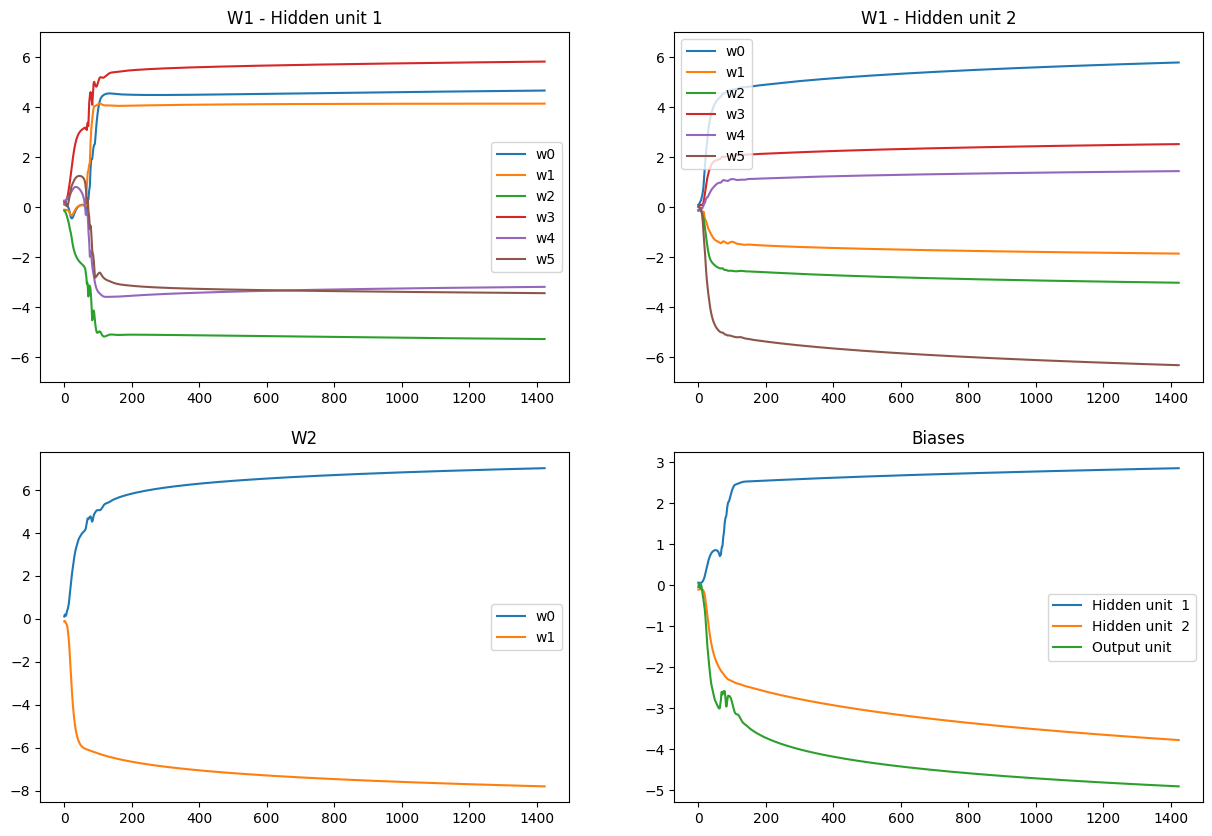

In [51]:
plot_weights_biases(w1, w2, b1, b2)

In [52]:
print_results(w1, w2, b1, b2, train_losses, test_losses, train_acc, test_acc)

Final weights 
[ 4.6694026  4.1464543 -5.271815   5.8277297 -3.183168  -3.4356441]
[ 5.792568  -1.8530862 -3.0181634  2.5267856  1.4461683 -6.3162484]

Final biases for the hidden layer
2.8610396
-3.7742202

Final weights for the output layer
7.018376
-7.8033476

Final bias for the output layer
-4.9042964

Final train and test losses: 2.7906e-02, 5.3481e-02
Final train and test accuracies: 0.9375, 0.8750


The resulting accuracy on the test set is good, as it is nearly 90%, despite the small dataset. The weights, however, do not respect the symmetries described in the paper.
The biases of the two hidden units are negative but not equal, while the two weights of the final layer are very similar to the ones in the paper.  
The loss does not tend asymptotically to 0, but to a greater value, so the probelm is not the number of epochs.  
I tried to use the weights given in the paper and the result is the following:

In [53]:
w1_paper = th.tensor([[14.2, -3.6, 7.2, -7.2, 3.6, -14.2],
                      [-14.2, 3.6, -7.2, 7.2, -3.6, 14.2]])
b1_paper = th.tensor([-1.1, -1.1])
w2_paper = th.tensor([-8.8, -8.8]).reshape(1, 2)
b2_paper = th.tensor([6.4])

model_paper = Model(w1_paper, w2_paper, b1_paper, b2_paper, 2)
y_true = test_loader.dataset.tensors[1]
y_pred = th.round(model_paper(test_loader.dataset.tensors[0])).detach().reshape(y_true.shape[0])



acc = th.sum(y_pred == y_true) / y_true.shape[0]

print(f"Test accuracy: {acc:.4f}")

Test accuracy: 1.0000


The accuracy is 100%, meaning that the model can provide a solution to the problem.

# Variation

In order to increase the perofmance, I tried to use a bigger dataset along with an overparametrised model.

In [61]:
train_elements: int = 2000
test_elements: int = 50

BATCH_SIZE: int = 64

train_input, train_output = create_input(train_elements)

test_input, test_output = create_input(test_elements)

train_dataset = TensorDataset(train_input, train_output)
train_loader = DataLoader(train_dataset, batch_size=BATCH_SIZE, shuffle=True)

test_dataset = TensorDataset(test_input, test_output)
test_loader = DataLoader(test_dataset, batch_size=BATCH_SIZE, shuffle=False)

In [62]:
n_units: int = 24
EPOCHS: int = 100
w1_init = (np.random.rand(n_units, 6) - 0.5) * 0.6
b1_init = (np.random.rand(n_units) - 0.5) * 0.6
w2_init = (np.random.rand(1, n_units) - 0.5) * 0.6
b2_init = (np.random.rand(1) - 0.5) * 0.6

model = Model(th.tensor(w1_init, dtype = th.float32),
              th.tensor(w2_init, dtype = th.float32),
              th.tensor(b1_init, dtype = th.float32),
              th.tensor(b2_init, dtype = th.float32),
              n_units)

criterion = CustomMSELoss()
optimizer = optim.SGD(model.parameters(), lr=0.01, momentum=MOMENTUM)

time_start = time.time()
model, train_losses, train_acc, test_losses, test_acc, w1, w2, b1, b2 = train_model(model, optimizer, criterion, train_loader, test_loader, EPOCHS, n_units)

print("Total time: ", time.time() - time_start)

100%|██████████| 100/100 [00:04<00:00, 20.35it/s]

Total time:  5.011957168579102


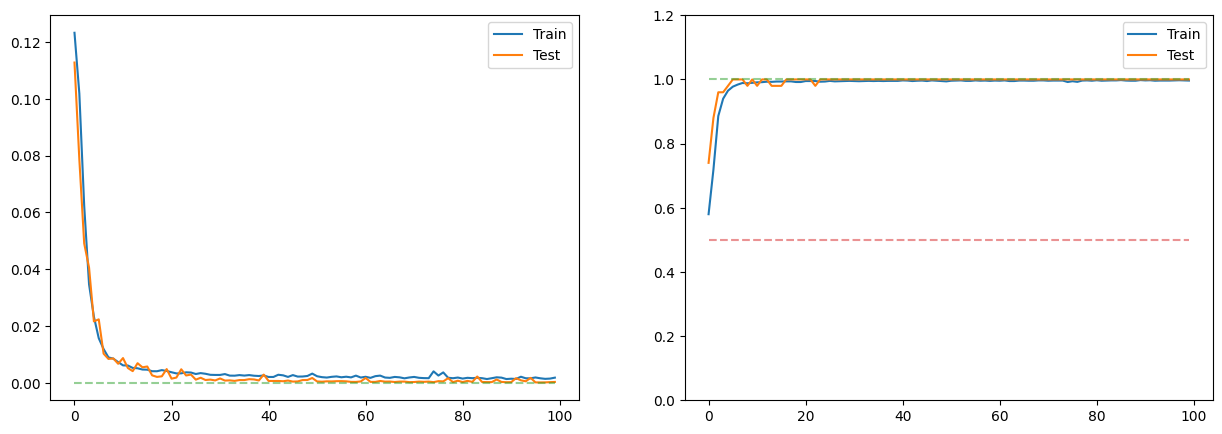

In [63]:
plot_loss_acc(train_losses, train_acc, test_losses, test_acc)

In [64]:
print_results(w1, w2, b1, b2, train_losses, test_losses, train_acc, test_acc)

Final weights 
[0.12412111 0.62003416 0.02752325 0.0813318  0.5818536  0.01812347]
[-3.7995744  -2.1264255   0.22092772 -0.13593474  2.1157272   3.6784708 ]
[ 0.5048175  -3.630447    2.7843525  -2.6889026   3.3802667  -0.59820896]
[-0.74855244 -0.07797765 -0.08130337 -0.12858187 -0.15929475 -0.65306664]
[-0.42352962 -0.05781933  0.22857769  0.14360583 -0.20974366 -0.36426434]
[ 0.05238605 -0.20567079 -0.31105927 -0.33971164  0.04576986  0.04141948]
[ 0.00755357 -0.3566072  -0.01645127  0.0006433  -0.15879318  0.06403307]
[-0.37732273 -0.11856707  0.22429916  0.16272768 -0.25763518 -0.2898028 ]
[-0.02624626 -0.0754341  -0.33646613 -0.3626134   0.13837449 -0.08584417]
[ 0.27372873  0.05163204 -0.04210304  0.00703345  0.11448833  0.1747438 ]
[ 2.5715945 -3.8294282  1.1881284 -1.1806183  3.8541002 -2.639986 ]
[-0.40714708  0.27922356 -2.6136692   2.7277453  -0.07469613  0.5676404 ]
[ 2.7656589  2.1980946  0.6211598 -0.9275927 -2.3209233 -2.7009096]
[ 0.251815    0.05055755 -0.22032423  0.2

By using 24 units on the hidden layer and a dataset of 2000 vectors, the result is far better than before: both the train and the test loss tend asymptotically to 0, both the accuracies reach nearly 100%, the number of epochs needed to reach those results is far smaller and, most importantly, the results are very similar not matter how many times I train the model.  
As expected, the weights are much smaller than before, and there seem to be no relevant symmetries; moreover, the second model does not require much more time than the first one to be trained.